# Getting Started with Projections

Here, we are showing some basic functionalities for analysing MD trajectories using `Projection` classes. First, let's import HTMD:

In [1]:
from htmd.ui import *
from moleculekit.config import config
from matplotlib import pylab as plt

config(viewer='webgl')

2024-06-11 18:08:42,913 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-11 18:08:42,914 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-06-11 18:08:43,027 - rdkit - INFO - Enabling RDKit 2022.09.1 jupyter extensions



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049
HTMD Documentation at: https://software.acellera.com/htmd/

You are on the latest HTMD version (2.3.28+7.g46a4ca83e.dirty).



## Projecting simulations

Get the data for this tutorial [here](http://pub.htmd.org/tutorials/projections/data.tar.gz). Alternatively, you can download the data using `wget`:

In [2]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/projections/data/') == 0

We will be doing two types of data projections:
* Projecting single Molecule objects
* Projecting lists of simulations

## Projecting single Molecule objects

One can load a previously simulated single MD trajectory (in this case, NTL9 protein) into a `Molecule` object and visualize it using:

In [3]:
mol = Molecule('data/ntl9_structure.psf')
mol.read('data/ntl9_trajectory.xtc')
mol.filter('protein')
mol.view()

2024-06-11 18:09:06,033 - moleculekit.molecule - INFO - Removed 17 atoms. 631 atoms remaining in the molecule.


NGLWidget(max_frame=9)

### Getting the RMSD along time

HTMD has many projection classes. One of those classes is `MetricRmsd`.

Using the `MetricRmsd` class, one may calculate the RMSD of a `Molecule` object against a reference structure (`refmol`, e.g. the crystal structure) for a given atom selection (`trajrmsdstr`):

In [4]:
crystal = Molecule('data/ntl9_crystal.pdb')
metr = MetricRmsd(refmol=crystal, trajrmsdstr='protein and name CA')
proj = metr.project(mol)
print(proj)

[16.360521  15.793981  14.122061  14.7720175 13.908776  12.928344
 11.541591  10.691926  10.778459  12.866117 ]


The values are in Angstroms. They are quite high values, because the sample trajectory is of the unfolded protein (see the visualization above).

### Plot the RMSD along time

The previously obtained RMSD values can be easily plotted using matplotlib:

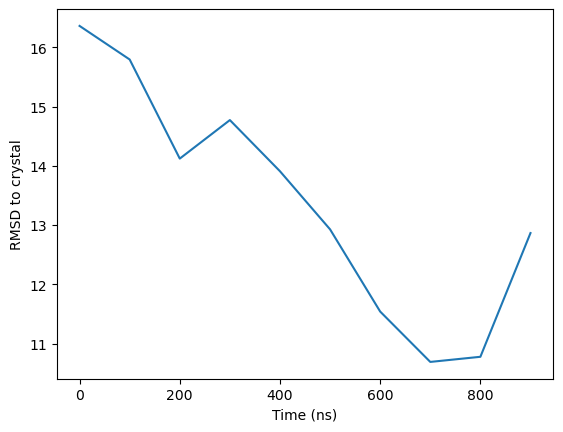

In [5]:
time_range = mol.fstep*np.arange(len(proj))
plt.plot(time_range, proj)
_ = plt.xlabel('Time (ns)')
_ = plt.ylabel('RMSD to crystal')

## Projecting a list of MD simulations

With the arrival of Markov state models, the paradigm of running one single long simulation has shifted to running hundreds or thousands of shorter simulations.

With the analysis of a large amount of MD trajectories in mind, in HTMD, the `simlist` function can be used to bundle all the trajectories together:

In [6]:
sims = simlist(glob('data/1/filtered/*/'), 'data/1/filtered/filtered.pdb')

Creating simlist: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2150.56it/s]


### Use Metric class to project a list of simulations

Using the `Metric` class, one can calculate all the projections of an entire simlist at once. In this case, the `MetricDistance` projection class is used, which calculates the matrix of distances between two selections (`sel1` and `sel2`):

In [7]:
metr = Metric(sims)
metr.set(MetricDistance(sel1='protein and name CA', sel2='resname MOL and noh', periodic='selections', metric='distances'))
data = metr.project()
data.fstep = 0.1

Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.45it/s]
2024-06-11 18:09:18,666 - htmd.projections.metric - INFO - Frame step 0.001ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


Here, the projection is the matrix of distances between each carbon alpha of the protein and each heavy atom of the MOL molecule (which in the case of these trajectories, it's a ligand binding to the protein)

The `Metric.project` method returns a `MetricData` object which contains the trajectory and projection information:

In [8]:
print(data)

MetricData object with 3 trajectories of 60.0ns aggregate simulation time
Centers: None
K: None
N: None
description: <class 'pandas.core.frame.DataFrame'> at 0x78decc2d44f0
fstep: 0.1
parent: <class 'NoneType'> at 0x55ab3b8027e0
trajectories shape: (3,)


## Working with MetricData objects

The `MetricData` object contains the information on each trajectory, including the corresponding projection. For example, for simulation 2:

In [10]:
print(data.trajectories[2])

sim: simid = 2
projection: np.array(shape=(200, 2493))
reference: np.array(shape=(200, 2))
cluster: None



The projection data can be easily accessed as a whole in the `MetricData.dat` property, which is an array of size equal to the number of trajectories. We can check the projection data of simulation 14 with:

In [11]:
data.dat[2]  # equivalent to data.trajectories[2].projection

array([[46.903584, 48.459248, 48.862976, ..., 52.245136, 51.477478,
        52.081757],
       [42.60737 , 42.6003  , 43.467403, ..., 46.8291  , 47.731323,
        45.771404],
       [45.674603, 44.244358, 44.22837 , ..., 53.92176 , 54.58503 ,
        53.017155],
       ...,
       [37.174904, 38.622143, 39.415646, ..., 37.552174, 37.359898,
        36.812588],
       [41.236233, 42.631603, 43.36949 , ..., 41.442356, 41.54479 ,
        41.618164],
       [45.716003, 45.90263 , 46.41945 , ..., 44.92147 , 44.872147,
        44.011333]], dtype=float32)

In [13]:
data.dat[2].shape

(200, 2493)

In [14]:
bundledprojs = np.vstack(data.dat) # np.concatenate can be used instead as well
print(bundledprojs.shape)

(600, 2493)


### Operations and calculations

One can use numpy functions like `np.min`, `np.max`, `np.average` to do calculations over the projected data:
* get the global minimum over all data

In [15]:
global_minimum = np.min(bundledprojs)
print(global_minimum)

3.2580273


* get the maximum distance on each frame:

In [16]:
max_eachframe = np.max(bundledprojs,axis=1)
print(max_eachframe.shape)
max_eachframe

(600,)


array([54.39825 , 53.998096, 55.228672, 51.56171 , 47.534378, 48.122726,
       54.234592, 52.287495, 56.084633, 59.717773, 58.638866, 59.020008,
       58.540077, 61.697826, 62.762337, 64.88375 , 57.164936, 61.46919 ,
       61.785923, 51.648315, 50.93795 , 49.167656, 51.03158 , 49.82826 ,
       50.78649 , 53.217636, 53.40074 , 54.59295 , 54.21768 , 49.040817,
       49.194637, 51.379505, 53.340816, 52.982063, 53.229916, 52.800793,
       51.121067, 50.52078 , 50.51849 , 53.35154 , 54.840214, 50.428257,
       46.97517 , 48.814857, 46.214386, 47.91875 , 46.25085 , 46.454384,
       48.536522, 47.89751 , 48.45051 , 47.181534, 50.3011  , 47.37468 ,
       44.809082, 44.76846 , 44.396427, 49.58187 , 49.452393, 44.699467,
       49.425236, 49.30479 , 48.831734, 48.04636 , 46.891056, 46.507465,
       53.23867 , 52.209763, 51.905357, 52.760147, 53.15323 , 52.926044,
       54.556217, 55.611897, 52.046055, 51.92997 , 50.818188, 51.01256 ,
       49.769115, 49.608753, 50.520557, 52.815094, 

* or get the average of each pair across all frames:

In [17]:
avg_acrossframes = np.average(bundledprojs,axis=0)
print(avg_acrossframes.shape)
avg_acrossframes

(2493,)


array([34.71057 , 34.667583, 34.678036, ..., 39.51156 , 39.480606,
       39.56731 ], dtype=float32)

The `axis` property is important to make the operation over the desired dimension:

* `axis=1`, in this case, operates over all pairs, to give a result for each frame
* `axis=0`, in this case, operates over all frames, to give a result for each pair

But how can we know to what particular atoms of the system corresponds a given indexed pair?

### Playing with the projection mapping

The mapping (meaning of each index) of the projection can be obtained from the `MetricData.map` property:

* the mapping is a pandas `DataFrame` object

The `head` method of `DataFrame` can be used to print the top entries of the mapping:

In [18]:
data.map.head()

,type,atomIndexes,description
0,distance,"[4, 4480]",distance between GLU 1 CA and MOL 278 C3
1,distance,"[4, 4483]",distance between GLU 1 CA and MOL 278 C2
2,distance,"[4, 4486]",distance between GLU 1 CA and MOL 278 C1
3,distance,"[4, 4489]",distance between GLU 1 CA and MOL 278 C6
4,distance,"[4, 4492]",distance between GLU 1 CA and MOL 278 C5


One can assess particular elements of the mapping through:

* `iloc` - i(nteger)loc(ation):

In [19]:
data.map.iloc[20:22]

,type,atomIndexes,description
20,distance,"[29, 4486]",distance between ASP 3 CA and MOL 278 C1
21,distance,"[29, 4489]",distance between ASP 3 CA and MOL 278 C6


 * `loc` (using the DataFrame index):

In [20]:
data.map.loc[20]

type                                           distance
atomIndexes                                  [29, 4486]
description    distance between ASP 3 CA and MOL 278 C1
Name: 20, dtype: object

* or direct assess to the array elements:

In [21]:
data.map['description'][20]

'distance between ASP 3 CA and MOL 278 C1'

One can use the mapping to find out to what particular pair of elements the minimum distance found in the trajectories corresponds to.

The `np.where` functionality gives us the array coordinates where a given condition is matched (in this case, when the distance is equal to the minimum):

In [22]:
print(global_minimum)
frame, index = np.where(bundledprojs == global_minimum)
print(index)
print(bundledprojs[frame, index]) # confirm that indeed these coordinates correspond the inquired value

3.2580273
[26]
[3.2580273]


Then, using the index in the mapping shown before:

In [23]:
data.map.iloc[index]

,type,atomIndexes,description
26,distance,"[29, 4500]",distance between ASP 3 CA and MOL 278 N2


gives us the atom indexes and description of the pair.